<h1> Exploratory Data Analysis <h1/>

<h3> DB Connection SQL Server <h3/>

In [1]:

# Load the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyodbc
import os
import seaborn as sns
import statsmodels.api as sm
import pylab as py

# seaborn graphics settings
sns.set(color_codes=True)

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Show current working directory
print(os.getcwd())

#DB-Connection
driver = '{ODBC Driver 17 for SQL Server}' # This might be a different version on your system
server = 'ANNINAYOGA\SQLEXPRESS'
database = 'Immo'
username = 'immoadmin'
password = 'zhaw$1234'
connection_string = f"DRIVER={driver};SERVER={server};DATABASE={database};Trusted_Connection=yes;"

#Connection and SQL-Query for table property
cnxn = pyodbc.connect(connection_string)
sql = "SELECT * FROM property"
df_property = pd.read_sql(sql,cnxn)  # without parameters [non-prepared statement]
cnxn.close()

#Connection and SQL-Query for table location
cnxn = pyodbc.connect(connection_string)
sql = "SELECT * FROM location"
df_location = pd.read_sql(sql,cnxn)  # without parameters [non-prepared statement]
cnxn.close()


C:\Users\AnninaBerweger\datascience-immo\Immo-Projekt-DataScience
<class 'pandas.core.frame.DataFrame'>
Index: 9000 entries, 0 to 11294
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   ListingId                     9000 non-null   object        
 1   Timestamp                     9000 non-null   datetime64[ns]
 2   Rooms                         9000 non-null   float64       
 3   SquareMeter                   9000 non-null   float64       
 4   Floor                         7922 non-null   object        
 5   Availability                  9000 non-null   object        
 6   ObjectType                    9000 non-null   object        
 7   YearBuilt                     4588 non-null   object        
 8   Price                         9000 non-null   float64       
 9   AdditionalCost                7534 non-null   float64       
 10  NetPrice                      8096

<h3>DB Connection MYSQL<h3/>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import statsmodels.api as sm
import pylab as py
from sqlalchemy import create_engine

# Database connection details
db_config = {
    'host': '127.0.0.1',
    'port': '13306',
    'user': 'admin',
    'password': 'admin123',
    'database': 'immo'
}

# Create the engine
engine = create_engine(f"mysql+mysqlconnector://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}")

# Querying the property table
query_property = "SELECT * FROM Property"
df_property = pd.read_sql(query_property, engine)

# Querying the location table
query_location = "SELECT * FROM Location"
df_location = pd.read_sql(query_location, engine)



<h3>Data Cleansing<h3/>

In [2]:
#Data Cleansing - run before EDA

# Performing a inner join on the two DataFrames to filter data which do not exist on location due to connection issues
df_filtered_property_location = pd.merge(df_property, df_location,on='LocationId', how='inner')

# filter out records with empty strings in the 'Rooms' column - new dataframe: df_filtered_property_location_clean
df_filtered_property_location_clean = df_filtered_property_location[df_filtered_property_location['Rooms'].notna()]

#Filter where ObjectType != Einzelzimmer, Estrichabteil, Hobbyraum or Kellerabteil
df_filtered_property_location_clean = df_filtered_property_location[(df_filtered_property_location['ObjectType'] != 'Einzelzimmer') & (df_filtered_property_location['ObjectType'] != 'Estrichabteil') & (df_filtered_property_location['ObjectType'] != 'Hobbyraum') & (df_filtered_property_location['ObjectType'] != 'Kellerabteil')]

#Check ObjectTypes - Einzelzimmer, Estrichabteil, Hobbyraum or Kellerabteil are filtered
df_filtered_property_location_clean.groupby("ObjectType").size()

# filter out records with empty strings in the 'Rooms' and 'SquareMeters' column
df_filtered_property_location_clean = df_filtered_property_location.dropna(subset=['Rooms', 'SquareMeter'])

#Check for empty records
df_filtered_property_location_clean.isnull().sum()

#after detecting outliers: check manually for noisy data (if not valid (selling house instead of renting), deleted the record in the df df_filtered_property_location_clean
ids_to_remove = ['4000895043','4000834270','4000895759','3003516605','4000910516','4000956535','4000924121','4000975051','4000888412','4000945522','4000869481','4000969667','4000838419','4000870455','4000904681','4000931326','4000969684','4000969684','4000797599','4000897187','4000969553','4000969553','4000965774','4000962388','4000969516','4000906960']  
df_filtered_property_location_clean = df_filtered_property_location_clean[~df_filtered_property_location_clean['ListingId'].isin(ids_to_remove)]

#Index: should have 9000 entries after running this code-snippet
df_filtered_property_location_clean.info()


<class 'pandas.core.frame.DataFrame'>
Index: 8998 entries, 1 to 11292
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   ListingId                     8998 non-null   object        
 1   Timestamp                     8998 non-null   datetime64[ns]
 2   Rooms                         8998 non-null   float64       
 3   SquareMeter                   8998 non-null   float64       
 4   Floor                         7920 non-null   object        
 5   Availability                  8998 non-null   object        
 6   ObjectType                    8998 non-null   object        
 7   YearBuilt                     4586 non-null   object        
 8   Price                         8998 non-null   float64       
 9   AdditionalCost                7533 non-null   float64       
 10  NetPrice                      8095 non-null   float64       
 11  LocationId                    8998

<h2>EDA<h2/>

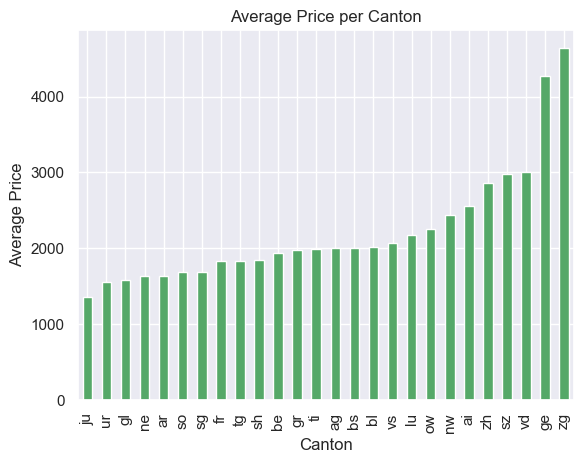

In [2]:
#Barplot average price / canton

average_prices = df_filtered_property_location_clean.groupby('Canton')['Price'].mean().sort_values()
average_prices.plot(kind='bar',color='g')
plt.title('Average Price per Canton')
plt.xlabel('Canton')
plt.ylabel('Average Price')

plt.show()


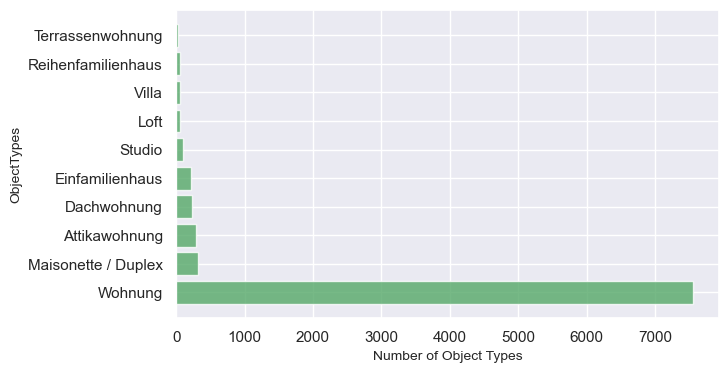

In [3]:
# Barchart top 10 ObjectTypes
#Group data by ObjectType (only the topmost 10 values are shown)
df_bar_property = df_filtered_property_location_clean['ObjectType'].value_counts().nlargest(10).sort_values(ascending=False)

# Values for barchart
napart = list(df_bar_property.values)
index = list(df_bar_property.index.values)
y_pos = np.arange(len(index))

# Figure
fig, ax = plt.subplots(figsize=(7,4))
ax.barh(y_pos, napart, align='center', color='g', alpha=0.8)
ax.set_yticks(y_pos, index)
ax.set_xlabel('Number of Object Types', fontsize=10)
ax.set_ylabel('ObjectTypes', fontsize=10)

# Show graph
plt.show()

<Axes: xlabel='SquareMeter'>

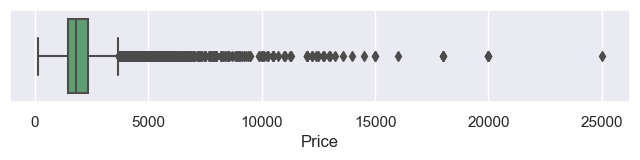

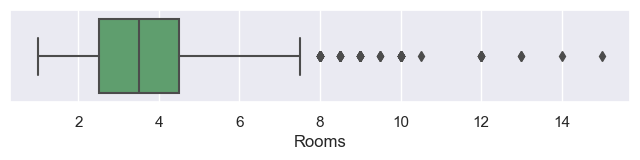

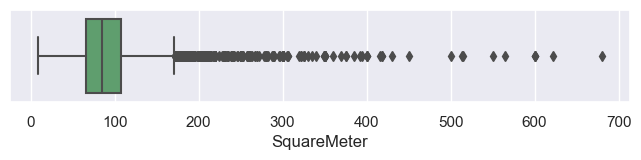

In [4]:
#Boxplots for Outliers of Prices, Rooms and SquareMeters
plt.figure(figsize=(8,1.2))
plt.ticklabel_format(style='plain')
sns.boxplot(x=df_filtered_property_location_clean['Price'], color="g")

plt.figure(figsize=(8,1.2))
plt.ticklabel_format(style='plain')
sns.boxplot(x=df_filtered_property_location_clean['Rooms'], color="g")

plt.figure(figsize=(8,1.2))
plt.ticklabel_format(style='plain')
sns.boxplot(x=df_filtered_property_location_clean['SquareMeter'], color="g")

In [ ]:
#weitere Beispiele EDA: 
#https://github.com/aberweger/Explorative_Data_Analysis_and_Visualization/blob/master/exploratory_data_analysis_apartments_data.ipynb
#https://seaborn.pydata.org/archive/0.11/generated/seaborn.barplot.html
#https://medium.com/analytics-vidhya/apartment-market-web-scrapping-and-eda-using-python-a9eacf6d64e2
#https://www.kaggle.com/code/dgawlik/house-prices-eda
